In [1]:
from a5_utils import *
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

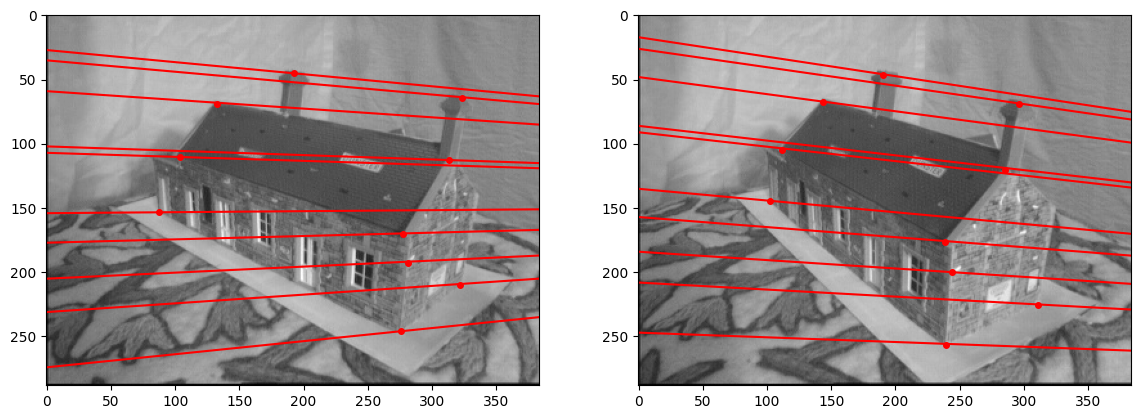

In [2]:
# (b) Implement a function fundamental_matrix that is given a set of (at least) eight pairs 
# of points from two images and computes the fundamental matrix using the eight-point algorithm.
def points_from_txt(path):
    data = np.loadtxt(path)
    x1 = data[:, 0]
    y1 = data[:, 1]
    x2 = data[:, 2]
    y2 = data[:, 3]

    points1 = []
    for i in range(len(x1)):
        points1.append([x1[i], y1[i]])

    points2 = []
    for i in range(len(x2)):
        points2.append([x2[i], y2[i]])
    return points1, points2

def fundamental_matrix(points1, points2):
    A = np.zeros((len(points1), 9))
    transformed1, T1 = normalize_points(np.array(points1))
    transformed2, T2 = normalize_points(np.array(points2))
    
    # construct A using the given equation
    for i in range(len(points1)):
        u1, v1, w1 = transformed1[i]
        u2, v2, w2 = transformed2[i]
        A[i] = [u1*u2, u1*v2, u1, v1*u2, v1*v2, v1, u2, v2, 1]
   
    U, S, V = np.linalg.svd(A)
    V = V.T
    f = V[:, -1]
    F = f.reshape((3, 3))
    #Decompose F
    U, S, V = np.linalg.svd(F)
    D = np.diag(S)
    D[-1] = 0
    #reconstruct F
    Ff = np.dot(U, D)
    Ff = np.dot(Ff, V)
    
    #denormalize F
    Ff = np.dot(T2.T, Ff.T)
    Ff = np.dot(Ff, T1)
    return Ff

house_1 = cv2.imread("data/epipolar/house1.jpg", cv2.IMREAD_GRAYSCALE) / 255
house_2 = cv2.imread("data/epipolar/house2.jpg", cv2.IMREAD_GRAYSCALE) / 255
height1, width1 = house_1.shape
height2, width2 = house_2.shape

points1, points2 = points_from_txt("data/epipolar/house_points.txt")
F = fundamental_matrix(points1, points2)
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(house_1, cmap="gray")
for i in range(len(points1)):
    plt.plot(points1[i][0], points1[i][1], 'ro', markersize=4)
# calculate epipolar line
for i in range(len(points2)):
    x = (points2[i][0], points2[i][1], 1)
    line = np.dot(F.T, x)
    draw_epiline(line, height1, width1)
plt.subplot(1, 2, 2)
plt.imshow(house_2, cmap="gray")
for i in range(0, len(points2)):
    plt.plot(points2[i][0], points2[i][1], 'ro',markersize=4)
for i in range(0, len(points1)):
    x = (points1[i][0], points1[i][1], 1)
    line = np.dot(F, x)
    draw_epiline(line, height2, width2)
plt.show()

In [3]:
# (c) Write a function reprojection_error that calculates the reprojection error of a 
# fundamental matrix F given two matching points. 

def reprojection_error(F, point1, point2):
    # [x,y,1]
    point1.append(1)
    point2.append(1)
    line1 = np.dot(F, point1)
    line2 = np.dot(F.T, point2)
    # get line equation
    a1, b1, c1 = line1
    a2, b2, c2 = line2
    
    #calculate distance
    d1 = abs(a1*point2[0] + b1*point2[1] + c1) / np.sqrt(a1**2 + b1**2)
    d2 = abs(a2*point1[0] + b2*point1[1] + c2) / np.sqrt(a2**2 + b2**2)

    average = (d1 + d2) / 2

    return average

point1 = [85, 233]
point2 = [67, 219]
error1 = reprojection_error(F, point1, point2)
print("Reprojection error of point1 and point2 is: ", error1)
average = 0
for i in range(len(points1)):
    average += reprojection_error(F, points1[i], points2[i])

average = average / len(points1)
print("Average error is: ", average)


Reprojection error of point1 and point2 is:  0.1467436557047638
Average error is:  0.3309133698053618
